In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import csv
import matplotlib.image as mpimg
from random import shuffle
import cv2

In [2]:
samples = []
file_path = './data/driving_log_advanced.csv'
#'./data/driving_log.csv'
with open(file_path) as csvfile:
	reader = csv.reader(csvfile)
	next(reader,None)
	for line in reader:
		samples.append(line)


from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

## 1. Dataset Summary & Exploration

In [3]:
def sample_img(source_path):
	filename = source_path.split('/')[-1]
	path = './data/IMG/' + filename
	image = mpimg.imread(path)
	return image

n_train = len(train_samples)
n_validation = len(validation_samples)
test_image = sample_img(train_samples[773][0])
image_shape = test_image.shape
angles = np.array(samples)[:,3].astype(float)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Steering angles range = {} ~ {}".format(min(angles), max(angles)))

Number of training examples = 8335
Number of validation examples = 2084
Image data shape = (160, 320, 3)
Steering angles range = -1.0 ~ 1.0


#### Distribution of the original sample training data
Here is an exploratory visualization of the data set. It is a bar chart showing how the data distribute over angles ranging from -1 to 1. Each bin represents certain range of angles and its height indicates how many examples in that range.

In [4]:
def show_histogram(angles, num_bins=21, title='Original samples'):
	num_bins = num_bins
	hist, bins = np.histogram(angles, bins=21)
	width = bins[1]-bins[0]
	plt.title(title)
	plt.ylabel('Number of samples')
	plt.xlabel('Steering angles')
	plt.bar(bins[:-1], hist, width=width, edgecolor="black", linewidth=1.2)
	plt.show()

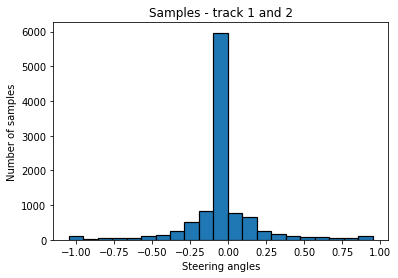

In [5]:
# Visualization of the provided sample data distribution
Y_train = np.array(samples)[:,3].astype(float)
show_histogram(list(Y_train), num_bins=25, title='Samples - track 1 and 2')

Steering angle = -0.401554


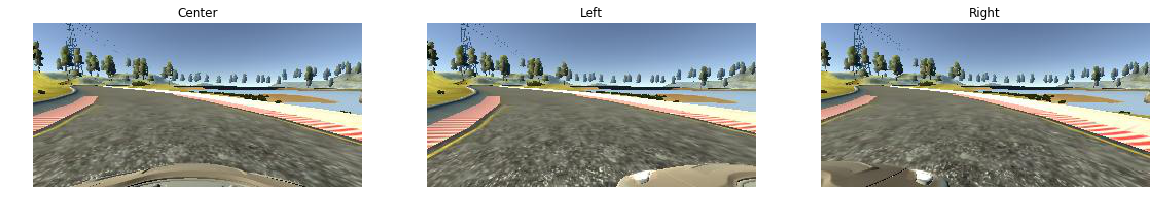

In [6]:
cameras = ['Center', 'Left', 'Right']
image_index = 773
test_sample = samples[image_index]
f, axs = plt.subplots(1, 3, figsize=(20,16))
axs = axs.ravel()
for i in range(3):
    image = sample_img(test_sample[i])
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(cameras[i])
print("Steering angle =", test_sample[3])

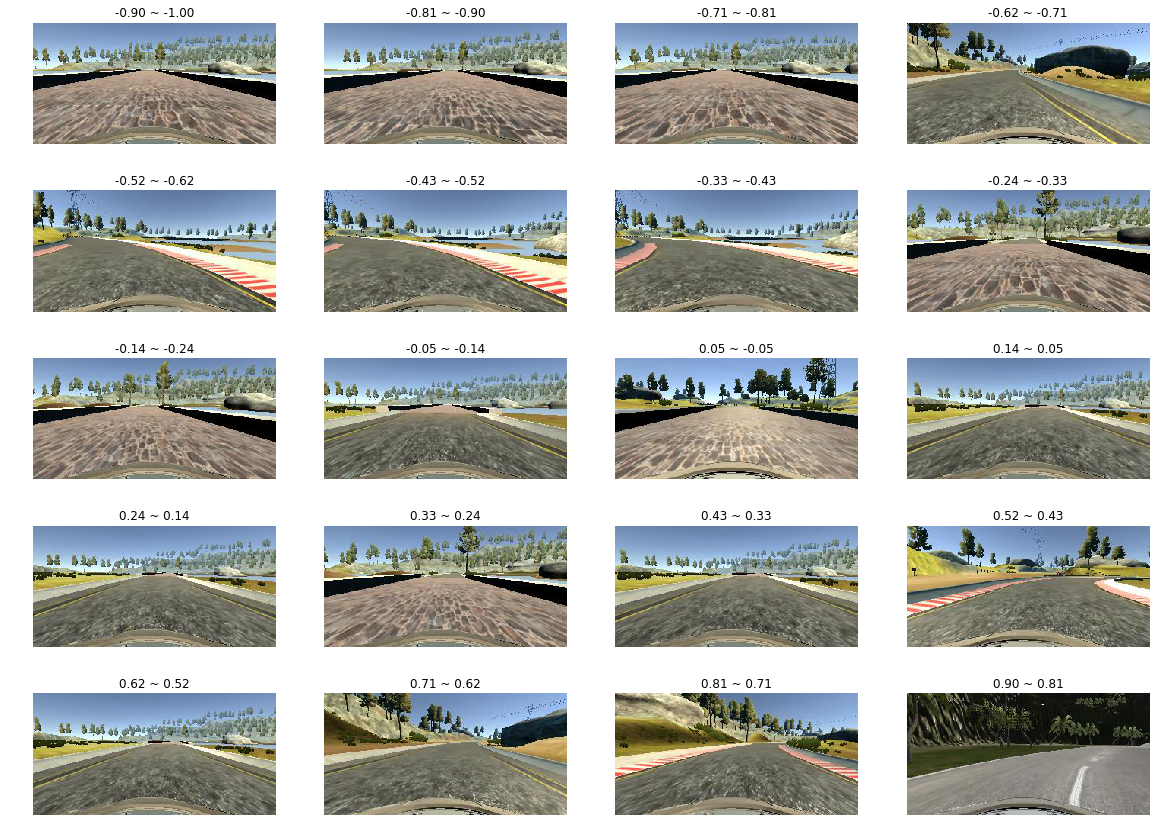

In [7]:
# Show one image per angle range
def show_images(X_data, y_data, num_bins=21, cmap=None):
    bin_edges = np.arange(-1,1,2/num_bins)
    n_col = 4
    n_row = int(np.ceil(num_bins/n_col))
    f, axs = plt.subplots(n_row, n_col, figsize=(20,3*n_row))
    axs = axs.ravel()
    for i in range(len(axs)):
        if i < len(bin_edges) - 1:
            min_edge = bin_edges[i]
            max_edge = bin_edges[i + 1]
            image_paths = X_data[(y_data >= min_edge) & (y_data < max_edge)]
            if len(image_paths) > 0:
                image = sample_img(image_paths[0])
            else:
                image = mpimg.imread('./examples/placeholder_small.png')
            axs[i].imshow(image, cmap=cmap)
            axs[i].axis('off')
            axs[i].set_title("{:.2f} ~ {:.2f}".format(max_edge, min_edge))
        else:
            f.delaxes(axs[i])
            
center_paths = np.array([s[0] for s in samples])
angles = np.array([s[3] for s in samples]).astype(float)
show_images(center_paths, angles)

## 2. Design and Test a Model Architecture

I started with NVIDIA model as my initial model, and separated the original samples into 80% training and 20% validation. Ran for 8 epochs with center camera images, and obtained an impressive result of training error 1.2% and validation 2.2%. 

However, when I tested the model on simulater, the car ran straight off the slightly curved road, shortly after the starting point. Clearly, the model's performance on simulator does not match with the obtianed errors.

I have a highly unbalanced dataset. The original samples have an excessive amount of small angles(i.e. straight) and stright roads. The model trained from these data will be highly biased towards driving straight. Also it's easier to predict correctly for straight road images, and hence the low error values.

### Data Selection

My model's performance on simulator doesn't match with the errors obtained, it's unclear if it's overfitting or underfitting, and we know that the original samples are highly biased towards driving straight. 

To overcome this, I decided to remove a 30% of the small angle samples first, then dividing the result into training and validation dataset. The obtained validation errors were much higher than training errors, and this furhter confirmed the overfitting.


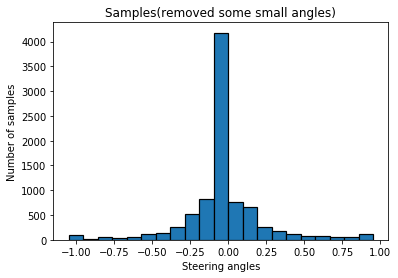

Number of training examples(dropped small angles) = 8621


In [10]:
def remove_small_angles(samples, drop_rate = 0.3):
	small_angle_samples = [s for s in samples if abs(float(s[3])) <= 0.05]
	shuffle(small_angle_samples)
	unwanted = small_angle_samples[:int(len(small_angle_samples)*drop_rate)]
	samples = [s for s in samples if s not in unwanted]
	return samples

samples_p = remove_small_angles(samples)
Y_data = np.array(samples_p)[:,3].astype(float)
show_histogram(list(Y_data), num_bins=25, title='Samples(removed some small angles)')

print("Number of training examples(dropped small angles) =", len(samples_p))

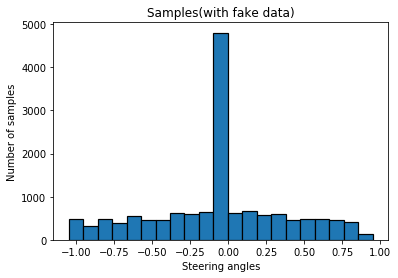

Number of training examples(with fake data) = 14662


In [11]:
def balance(samples, num_bins=25):
	bin_edges = np.arange(-1,1,2/num_bins)
	np.append(bin_edges,1)
	avg_bin_count = int(len(samples)/num_bins)
	for idx, value in enumerate(bin_edges[:-1]):
		bin_samples = [s for s in samples if float(s[3]) >= bin_edges[idx] and float(s[3]) < bin_edges[idx+1]]
		bin_count = len(bin_samples)
		if bin_count > 0:
			if bin_count <= avg_bin_count:
				multiplier = int(avg_bin_count/bin_count)
				remainder = int(avg_bin_count%bin_count)       
				samples.extend(bin_samples*multiplier)
				samples.extend(bin_samples[:remainder])
	return samples

train_samples_p = balance(train_samples)
Y_data = np.array(train_samples_p)[:,3].astype(float)
show_histogram(list(Y_data), num_bins=25, title='Samples(with fake data)')

print("Number of training examples(with fake data) =", len(train_samples_p))

### Data Augmentation
In order to overcome overfitting, I decided to apply data augmentation.

#### Flipping 
I randomly flipped images vertically and inversed the sign of the angle.


In [12]:
def show_processed_image(original, processed, title='original', p_title="processed"):
    index = 0#random.randint(0, len(x_data))
    f, axs = plt.subplots(1, 2, figsize=(10,3))
    axs = axs.ravel()
    axs[0].axis('off')
    axs[0].imshow(original)
    axs[0].set_title(title)
    axs[1].axis('off')
    axs[1].imshow(processed)
    axs[1].set_title(p_title)

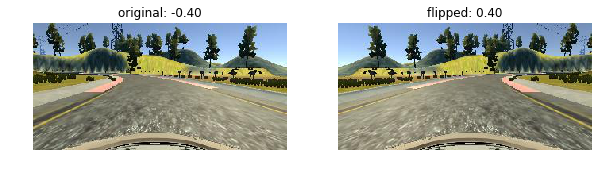

In [13]:
flipped_image = np.fliplr(test_image)
test_angle = float(samples[image_index][3])
flipped_angle = -test_angle
show_processed_image(test_image, flipped_image, title='original: {:.2f}'.format(test_angle), p_title='flipped: {:.2f}'.format(flipped_angle))

#### Random Brightness

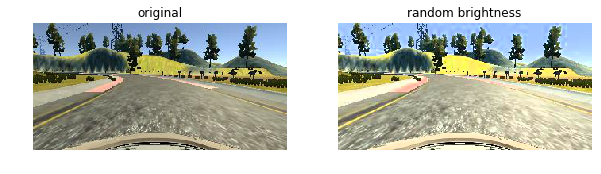

In [14]:
def brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2BGR)
    return image1

brightness_image = brightness(test_image)
show_processed_image(test_image, brightness_image, p_title='random brightness')

#### Random Translation
I randomly translated the image and add corresponding offset to its steering angle.

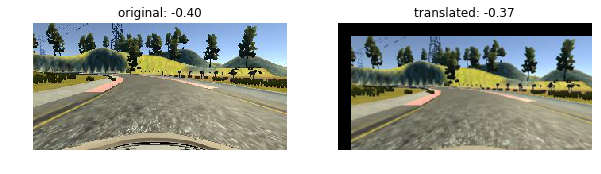

In [15]:
def translate(image, steering):
    trans = 100*np.random.uniform()-50
    M = np.float32([[1,0,trans],[0,1,trans]])
    image = cv2.warpAffine(image, M, image.shape[::-1][1:])
    steering += trans*0.002
    return image, steering
translate_image, translate_angle = translate(test_image, test_angle)
show_processed_image(test_image, translate_image, title='original: {:.2f}'.format(test_angle), p_title='translated: {:.2f}'.format(translate_angle))

#### Using Multiple Camera
The simulator captures images from three cameras mounted on the car, a center, right, and left camera. In order to train the model to recover from the sides of the road back to center, during training I chose image randomly from one of the cameras, and add/substract from the center angle as if they were coming from the center camera. 

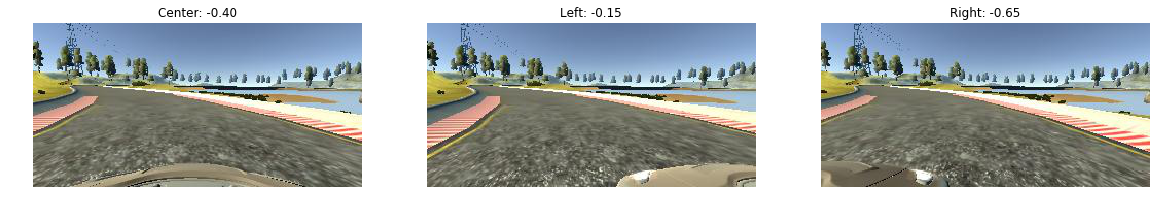

In [16]:
cameras = ['Center', 'Left', 'Right']
corrections = [0, 0.25, -0.25]
image_index = 773
test_sample = samples[image_index]
f, axs = plt.subplots(1, 3, figsize=(20,16))
axs = axs.ravel()
for i in range(3):
    image = sample_img(test_sample[i])
    angle = float(test_sample[3]) + corrections[i]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title("{}: {:.2f}".format(cameras[i], angle))


### Pre-processing the Data Set

#### 1. Normalization

The image data is normalized so that the data are between 0 to 1 and has equal variance. (pixel / 255) is used in this project. In the actual model, I used Keras' lambda layer to apply normalization. 

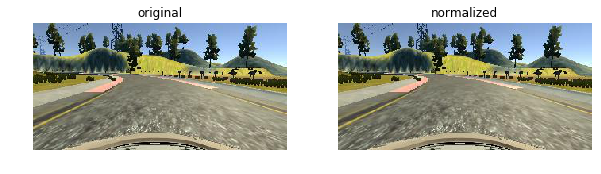

In [17]:
normalized_image = test_image / 255
show_processed_image(test_image, normalized_image, p_title='normalized')

Normalization effectively decreased the training time. 

#### 2. HSV Conversion
I converted the image into HSV and YUV color spaces and compared each individual color channels. It was easy to see that the S Channel from HSV space provides a more clear way to distinguish the road from other parts of the image.

A Keras lambda layer is used in the actual model, and I used OpenCV to convert the color spaces below for visualization.

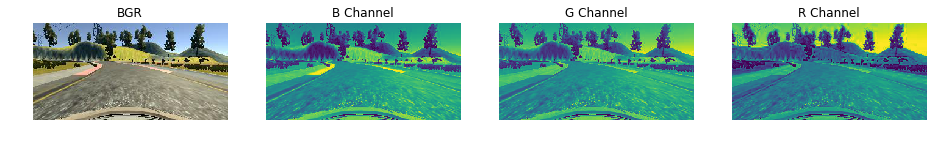

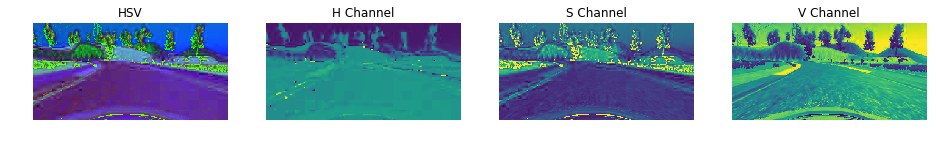

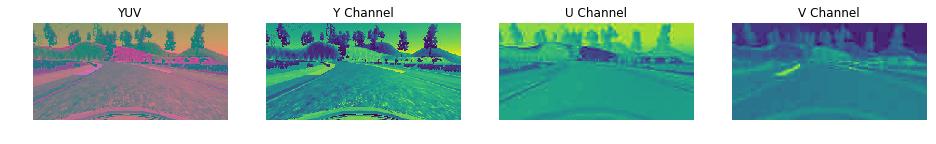

In [18]:
def rgb2hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def rgb2yuv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

def show_color_spaces(img, titles=[None]*3, cmap=None):
    f, axs = plt.subplots(1, 4, figsize=(16,3))
    axs = axs.ravel()
    for i in range(len(axs)):  
        axs[i].axis('off')
        if i == 0:
            axs[i].imshow(img)
        else:
            axs[i].imshow(img[:,:,i-1])
        axs[i].set_title(titles[i])

show_color_spaces(test_image, titles=['BGR','B Channel','G Channel','R Channel'])
hsv_image = rgb2hsv(test_image)
show_color_spaces(hsv_image, titles=['HSV','H Channel','S Channel','V Channel'])
yuv_image = rgb2yuv(test_image)
show_color_spaces(yuv_image, titles=['YUV','Y Channel','U Channel','V Channel'])

I decided to use S Channel for the input images. This will greatly reduce the data size and training time.

#### 3. Cropping

The cameras are mounted to the front of the car, and the road will always appear in the same general region in the image. By keeping the useful information and removing top(trees, hill, and sky) and bottom(hood of car) portions, the model might train faster.

In the model, I used Keras' Cropping2D layer to remove the useless parts. For visualization purpose, I used OpenCV to crop the image here.


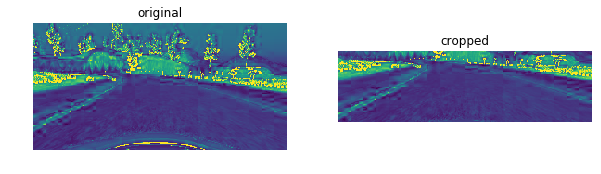

In [19]:
s_image = hsv_image[:,:,1]
crop_img = s_image[50:-20,:]
show_processed_image(s_image, crop_img, p_title='cropped')

### Loss Visualization

In [20]:
def plot_loss(loss, val_loss):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

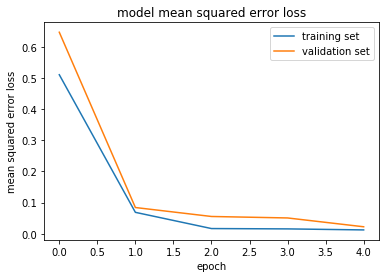

In [21]:
loss = [0.51062601618303538, 0.068840290083572384, 0.016752190338294507, 0.015688116787777047, 0.012403224348949944]
val_loss = [ 0.6469969995788476, 0.084296277792859586, 0.055540236281747979, 0.050808191639896125, 0.022497751564995044]
plot_loss(loss, val_loss)

Note: The validation errors don't match with the test result on simulator. The car ran off the road shortly after the starting point. 

This might be  by the highly unbalanced data distribution, small angle samples are overly represented and the actual validation loss should be higher than what was obtained.